### Example Heatmap and Response

This script will generate example of all cell response, with example response.

In [1]:
#%%
from Cell_Class.Stim_Calculators import Stim_Cells
from Cell_Class.Format_Cell import Cell
import OS_Tools_Kit as ot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import cv2
from Kill_Cache import kill_all_cache
from sklearn.model_selection import cross_val_score
from sklearn import svm
from scipy.stats import pearsonr
import scipy.stats as stats
from Cell_Class.Plot_Tools import Plot_3D_With_Labels
import copy
from Cell_Class.Advanced_Tools import *
from Classifier_Analyzer import *
from Cell_Class.Timecourse_Analyzer import *


wp = r'D:\_All_Spon_Data_V1\L76_18M_220902'
ac = ot.Load_Variable_v2(wp,'Cell_Class.pkl')
spon_series = ot.Load_Variable(wp,'Spon_Before.pkl').reset_index(drop = True)


import warnings
warnings.filterwarnings("ignore")

___
Step1, Generate example matrix for plot.
We use Orientation Run as Stim example.

In [2]:
# get spon,stim,shuffle frames.
orien_series = ac.Z_Frames['1-007']
spon_shuffle = Spon_Shuffler(spon_series,method='phase') # use phase shuffle to make power phase random.
spon_shuffle_frame = pd.DataFrame(spon_shuffle,columns = spon_series.columns,index = spon_series.index)

# sort all frame by orientation tuning, to make cluster easy to recognize.
rank_index = pd.DataFrame(index = ac.acn,columns=['Best_Orien','Sort_Index','Sort_Index2'])
for i,cc in enumerate(ac.acn):
    rank_index.loc[cc]['Best_Orien'] = ac.all_cell_tunings[cc]['Best_Orien']
    if ac.all_cell_tunings[cc]['Best_Orien'] == 'False':
        rank_index.loc[cc]['Sort_Index']=-1
        rank_index.loc[cc]['Sort_Index2']=0
    else:
        orien_tunings = float(ac.all_cell_tunings[cc]['Best_Orien'][5:])
        # rank_index.loc[cc]['Sort_Index'] = np.sin(np.deg2rad(orien_tunings))
        rank_index.loc[cc]['Sort_Index'] = orien_tunings
        rank_index.loc[cc]['Sort_Index2'] = np.cos(np.deg2rad(orien_tunings))
# actually we sort only by raw data.
sorted_cell_sequence = rank_index.sort_values(by=['Sort_Index'],ascending=False)
# and we try to reindex data.
sorted_stim_response = orien_series.T.reindex(sorted_cell_sequence.index).T
sorted_spon_response = spon_series.T.reindex(sorted_cell_sequence.index).T
sorted_shuffle_response = spon_shuffle_frame.T.reindex(sorted_cell_sequence.index).T

___
Plot Graph 1-FGH, Heatmaps.

<Figure size 640x480 with 0 Axes>

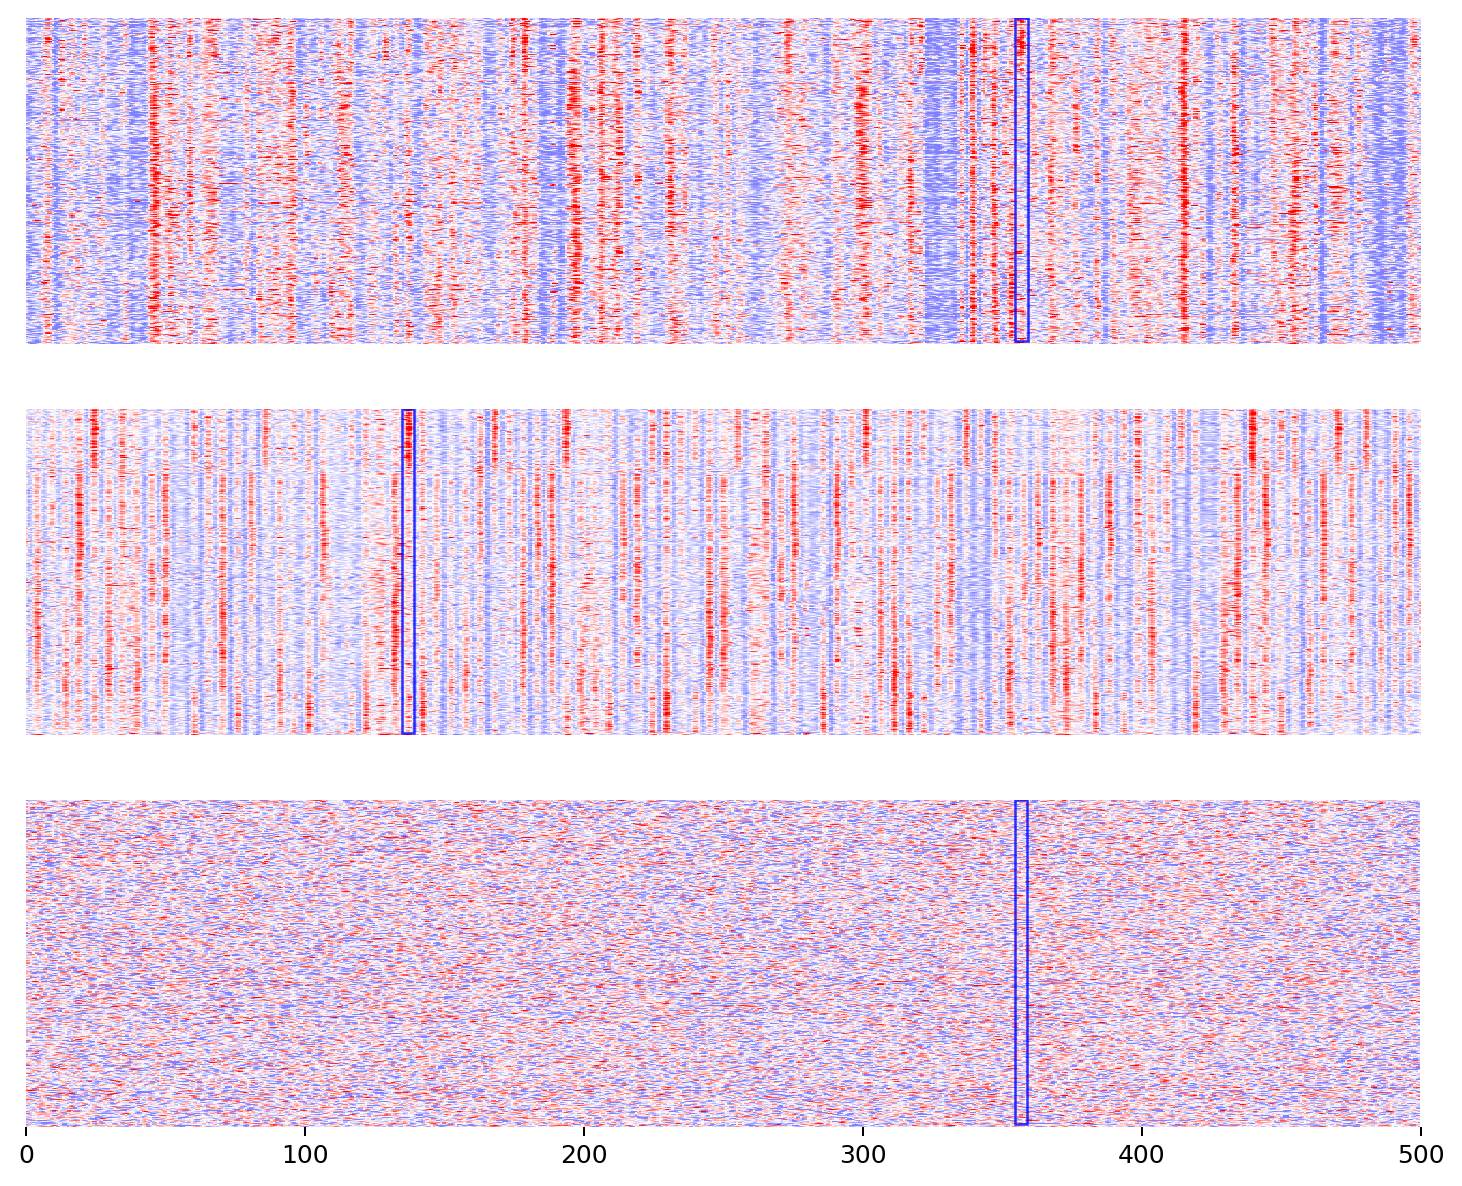

In [6]:
plt.clf()

vmax = 4
vmin = -2
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,8),dpi = 180)
label_size = 10

# Plot Core Heatmap
sns.heatmap(sorted_spon_response.iloc[4700:5350,:].T,center = 0,xticklabels=False,yticklabels=False,ax = axes[0],vmax = vmax,vmin = vmin,cbar= False,cmap = 'bwr')
sns.heatmap((sorted_stim_response .iloc[1000:1650,:].T),center = 0,xticklabels=False,yticklabels=False,ax = axes[1],vmax = vmax,vmin = vmin,cbar= False,cmap = 'bwr')
sns.heatmap(sorted_shuffle_response.iloc[4700:5350,:].T,center = 0,xticklabels=False,yticklabels=False,ax = axes[2],vmax = vmax,vmin = vmin,cbar= False,cmap = 'bwr')

# Plot annotate rectangle.
from matplotlib.patches import Rectangle
axes[0].add_patch(Rectangle((461,0), 6, 520, fill=False, edgecolor='blue', lw=1,alpha = 0.8))
axes[1].add_patch(Rectangle((175,0), 6, 520, fill=False, edgecolor='blue', lw=1,alpha = 0.8))
axes[2].add_patch(Rectangle((461,0), 6, 520, fill=False, edgecolor='blue', lw=1,alpha = 0.8))

# set time scale in seconds
fps = 1.301
axes[2].set_xticks([0*fps,100*fps,200*fps,300*fps,400*fps,500*fps])
axes[2].set_xticklabels([0,100,200,300,400,500],fontsize = label_size)
plt.show()

___
Plot Fig 1-IJK, example response frames in rectangle above

In [7]:
# set the location of each rectangle.
stim_start_point = 175
spon_start_point = 461

# get average response of 6 frame.
stim_recover = orien_series.loc[1000+stim_start_point:1000+stim_start_point+6].mean(0)
spon_recover = spon_series.loc[4700+spon_start_point:4700+spon_start_point+6].mean(0)
shuffle_recover = spon_shuffle_frame.loc[0+spon_start_point:0+spon_start_point+6].mean(0)

# plot response into graph
stim_recover_map = ac.Generate_Weighted_Cell(stim_recover)
spon_recover_map = ac.Generate_Weighted_Cell(spon_recover)
shuffle_recover_map = ac.Generate_Weighted_Cell(shuffle_recover)

<Figure size 640x480 with 0 Axes>

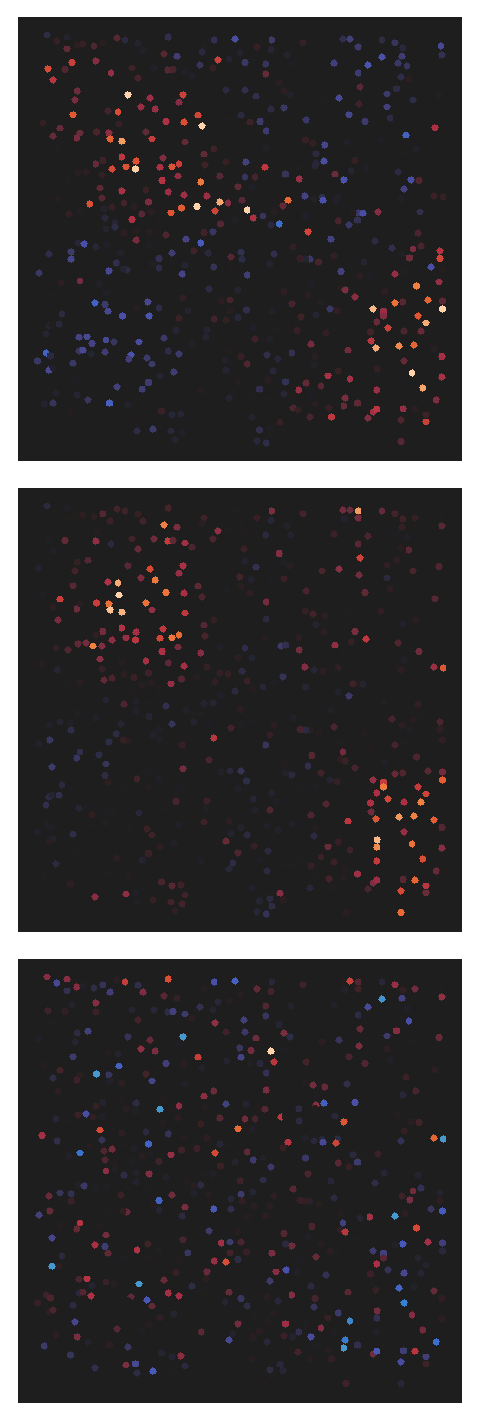

In [9]:
# plot part
plt.clf()

vmax = 3
vmin = -2

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5,8),dpi = 180)
fig.tight_layout()
sns.heatmap(spon_recover_map,center=0,xticklabels=False,yticklabels=False,ax = axes[0],vmax = vmax,vmin = vmin,cbar= False,square=True)
sns.heatmap(stim_recover_map,center = 0,xticklabels=False,yticklabels=False,ax = axes[1],vmax = vmax,vmin = vmin,cbar= False,square=True)
sns.heatmap(shuffle_recover_map,center=0,xticklabels=False,yticklabels=False,ax = axes[2],vmax = vmax,vmin = vmin,cbar= False,square=True)


fig.tight_layout()
plt.show()